## Simulating Chaotic Rayleigh-Benard Convection in Firedrake

This is a simplified 2D model that can be thought of a top and a bottom plate with a liquid in constant phase. The bottom plate is being held at a constant temperature $T_0$ while the top plate is being held at a constant temperature $T_1$. 

Consider the two cases:

case 1:

$T_0 < T_1$

case 2:

$T_0 > T_1$

Case 1 is stable, the fluid on top is less dense than the fluid at the bottom, the expected behavior will result in an equilibrium. On the other hand, case 2 is not stable, when the bottom plate has a higher temperature than the top plate, it will result in the top liquid having a higher density than the bottom liquid. If the temperature gradient is high enough, the bouyancy force will cause the bottom liquid to rise and the top liquid to sink. This convection is Rayleigh-Benard Convection and will only occur when the boyancy force is able to overcome the frictional (viscosity) and gravitational forces that usually keep the lower liquid at the bottom.


bouyancy acts
viscocsity acts as a friction and opposes the liquid going up


### Equations for Convection

In order to simplify the equations, we have to make assumptions to derive the Boussinesq approximation

1. Te depth of the fluid is small relative to the hydrostatic scale heights of pressure, tempearture and density.  In other words, we assume the liquid is shallow.

2. Density fluctuations are thermal, not pressure driven.

3. The flow speed is much less than the speed of sound.

Momentum Conservation (Navier Stokes equation)

\begin{align} 
\frac{\partial u}{\partial t} - \Delta u + u \cdot \nabla u + \nabla p + \frac{Ra}{Pr} T =  0 \\
\end{align}

Mass Conservation

\begin{align} 
\nabla \cdot u = 0 \\
\end{align}

Energy Conservation

\begin{align} 
\frac{\partial T}{\partial t} - \frac{1}{Pr} \Delta T +  u \cdot \nabla T = 0
\end{align}


In [1]:
from firedrake import *
from firedrake.petsc import PETSc
import matplotlib.pyplot as plt

## Meshes

To demonstrate the structure of the mesh along with the borders and their associated numbers, a 10x10 mesh is shown in figure 1. The numbers assigned to each border are necessary when defining boundary conditions.

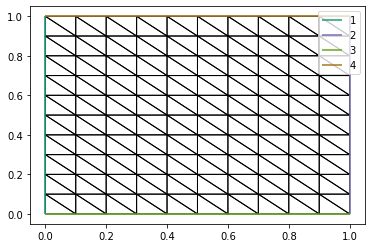

In [2]:
N = 10
mesh = UnitSquareMesh(N, N)
fig, axes = plt.subplots()
triplot(mesh, axes=axes)
axes.legend();

Our true mesh will be 128x128 cells.

In [3]:
N = 64
mesh = UnitSquareMesh(N, N)

In [4]:
#polynomial degree of the pressure space
degree = 1

V = VectorFunctionSpace(mesh, "CG", degree + 1)
V_out = VectorFunctionSpace(mesh, "CG", degree)
P = FunctionSpace(mesh, "CG", degree)
T = FunctionSpace(mesh, "CG", degree)
Z = V * P * T

#upT = Function(Z, name="upT")
upT_ = Function(Z, name="upT_prev")
upT = Function(Z, name='upT')

u, p, Temp = split(upT)
u_, p_, Temp_ = split(upT_)
v, q, S = TestFunctions(Z)


### Constants

Two key physical parameters are the Rayleigh number, $Ra$, and the Prandtl number, $Pr$. $Ra$ can be used to quantify the 'amount of convection' in a flow, and measures the ratio of energy from buoyant forces to viscous dissipation and heat conduction. $Pr$ measures the ratio of viscosity to heat conduction.

\begin{align}
Ra = \frac{\alpha \beta g \Delta T h^3}{\nu \kappa}
Pr = \frac{\mu C_p}{k} \\
\end{align}


In [5]:
Ra = Constant(2e4)
Pr = Constant(1)

# gravity points down
g = Constant((0, -1))

dt = .1

In [6]:
# weak formulation of momentum equation
F0 =   ( inner(u - u_, v) / dt 
     + inner(grad(u), grad(v)) 
     + inner(dot(grad(u), u), v) 
     - inner(p, div(v))
     - (Ra/Pr)*inner(Temp*g, v))*dx

# weak formulation of mass equation
F1 = inner(div(u), q)*dx

# weak formulation for energy equation
F2 = ((Temp - Temp_) * S / dt  + inner(dot(grad(Temp), u), S)
      + 1/Pr * inner(grad(Temp), grad(S)))*dx

F = F0 + F1 + F2

### Boundary Conditions

Heat is applied from bottom to top so that the temperature gradient is enforced parallel to the graviation.

\begin{align} 
v = 0, T = 0.0, bottom \\
v = 0, T = 1.0, top \\
v = 0, left \\
v = 0, right \\
\end{align}

The stress-free Direclet boundary condition sets the velocity to zero for all boundaries.

The Temperature is kept constant for the top and bottom, zero for the op and one for the bottom.

With the lower temperature on the top and higher temperature on the bottom, that will result in higher density at the top and lower density at the bottom. The higher density fluid will sink, resulting in a circular motion for the fluid.




In [7]:
# TODO: Neumann boundary for left/right sides for insulation 
# heat flux = 0

bcs = [
    DirichletBC(Z.sub(0), Constant((0, 0)), (1, 2, 3, 4)), 
    DirichletBC(Z.sub(2), Constant(1.0), (3,)),
    DirichletBC(Z.sub(2), Constant(0.0), (4,))
]


nullspace = MixedVectorSpaceBasis(
    Z, [Z.sub(0), VectorSpaceBasis(constant=True), Z.sub(2)])

In [8]:
parameters1 = {"mat_type": "matfree",
              "snes_monitor": None,
              "ksp_type": "gmres",
              "pc_type": "fieldsplit",
              "pc_fieldsplit_type": "multiplicative",

# We want to split the Navier-Stokes part off from the temperature
# variable. ::

              "pc_fieldsplit_0_fields": "0,1",
              "pc_fieldsplit_1_fields": "2",

# We'll invert the Navier-Stokes block with MUMPS::

              "fieldsplit_0_ksp_type": "preonly",
              "fieldsplit_0_pc_type": "python",
              "fieldsplit_0_pc_python_type": "firedrake.AssembledPC",
              "fieldsplit_0_assembled_pc_type": "lu",
              "fieldsplit_0_assembled_pc_factor_mat_solver_type": "mumps",

# the temperature block will also be inverted directly, but with plain
# LU.::

              "fieldsplit_1_ksp_type": "preonly",
              "fieldsplit_1_pc_type": "python",
              "fieldsplit_1_pc_python_type": "firedrake.AssembledPC",
              "fieldsplit_1_assembled_pc_type": "lu"}

parameters2 = {"mat_type": "matfree",
              "snes_monitor": None,

# We'll use inexact GMRES solves to invert the Navier-Stokes block, so
# the preconditioner as a whole is not stationary, hence we need
# flexible GMRES. ::

             "ksp_type": "fgmres",
             "ksp_gmres_modifiedgramschmidt": True,
             "pc_type": "fieldsplit",
             "pc_fieldsplit_type": "multiplicative",

# Again we split off Navier-Stokes from the temperature block ::

             "pc_fieldsplit_0_fields": "0,1",
             "pc_fieldsplit_1_fields": "2",

# which we solve inexactly using preconditioned GMRES. ::

             "fieldsplit_0": {
                 "ksp_type": "gmres",
                 "ksp_gmres_modifiedgramschmidt": True,
                 "ksp_rtol": 1e-2,
                 "pc_type": "fieldsplit",
                 "pc_fieldsplit_type": "schur",
                 "pc_fieldsplit_schur_fact_type": "lower",

# Invert the velocity block with a single V-cycle of algebraic
# multigrid::

                 "fieldsplit_0": {
                     "ksp_type": "preonly",
                     "pc_type": "python",
                     "pc_python_type": "firedrake.AssembledPC",
                     "assembled_pc_type": "hypre"
                 },

# and approximate the Schur complement inverse with PCD. ::

                 "fieldsplit_1": {
                      "ksp_type": "preonly",
                      "pc_type": "python",
                      "pc_python_type": "firedrake.PCDPC",

# We need to configure the pressure mass and Poisson solves, along with
# how to apply the convection-diffusion operator.  For the latter, we
# will use an assembled operator this time round. ::

                      "pcd_Mp_ksp_type": "preonly",
                      "pcd_Mp_pc_type": "ilu",
                      "pcd_Kp_ksp_type": "preonly",
                      "pcd_Kp_pc_type": "hypre",
                      "pcd_Fp_mat_type": "aij"
                 }
             },

# Now for the temperature block, we use a moderately coarse tolerance
# for algebraic multigrid preconditioned GMRES. ::

            "fieldsplit_1": {
                 "ksp_type": "gmres",
                 "ksp_rtol": "1e-4",
                 "pc_type": "python",
                 "pc_python_type": "firedrake.AssembledPC",
                 "assembled_pc_type": "hypre"
            }
       }



In [9]:
# First off, we'll solve the full system using a direct solver.  As
# previously, we use MUMPS, so wrap the solve in ``try/except`` to avoid
# errors if it is not available. ::
solve(F == 0, upT, bcs=bcs, nullspace=nullspace,
      solver_parameters={"mat_type": "aij",
                        "snes_monitor": None,
                        "ksp_type": "gmres",
                        "pc_type": "lu",
                        "pc_factor_mat_solver_type": "mumps"})

upT.assign(0)
solve(F == 0, upT, bcs=bcs, nullspace=nullspace,
      solver_parameters=parameters1)



In [10]:
appctx = {"velocity_space": 0}
upT.assign(0)
u, p, Temp = upT.split()

outfile = File("sim.pvd")
outfile.write(project(u, V_out, name="Velocity"))


upT_.assign(0)
t = 0.0
end = 1

results = [project(u, V_out, name="Velocity")]
while (t <= end):
    t += dt
    
    solve(F == 0, upT, bcs=bcs, nullspace=nullspace,
          solver_parameters=parameters2, appctx=appctx)
    upT_.assign(upT)
    u, p, Temp = upT.split()
    results.append(project(u, V_out, name="Velocity"))
    outfile.write(project(u, V_out, name="Velocity"))



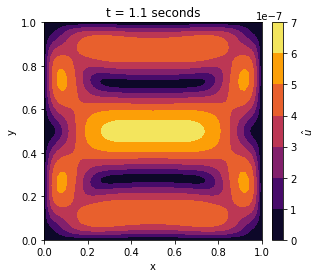

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation

fig = plt.figure()
ax = fig.add_subplot(111)

# I like to position my colorbars this way, but you don't have to
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')

def animate(i):
    u = results[i]
    t = round(i*dt, 1)
    ax.clear()
    
    ax.set_aspect("equal")
    contours = tricontourf(u,  axes=ax, cmap="inferno")
    cax.cla()
    cb = fig.colorbar(contours, cax=cax)
    ax.set_title('t = {} seconds'.format(t))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    cb.set_label('$\hat{u}$')
    
interval = 6e3 * float(dt)
anim = FuncAnimation(fig, animate, frames=len(results), interval=interval)


f = '/home/user/ATOC/final/results_0.gif'
writergif = animation.PillowWriter(fps=2) 
anim.save(f, writer=writergif)

from IPython.display import HTML
HTML(anim.to_jshtml())